In [93]:
# !pip install nltk
# nltk.download('punkt')
# nltk.download('stopwords')

In [94]:
import pandas as pd
import numpy as np

import requests

import re

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


#instalamos una libreria de gender guesser https://pypi.org/project/gender-guesser/
!pip install gender_guesser
!pip install xlrd
!pip install openpyxl
import gender_guesser.detector as gender


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data

In [95]:
# data = pd.read_csv('/content/ACL_data.csv')
data = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/ACL_data_without_nulls.csv")
data.head(3)

,YEAR,TITLE,ABSTRACT,AUTHOR,PUBLISHER,BOOKTITLE,CATEGORY
0,2022,A Systematic Survey of Text Worlds as Embodied...,Text Worlds are virtual environments for embod...,"Jansen, Peter",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS
1,2022,A Minimal Computational Improviser Based on Or...,A prototype system for playing a minimal impro...,"Montfort, Nick and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS
2,2022,Craft an Iron Sword: Dynamically Generating In...,Non-Player Characters (NPCs) significantly enh...,"Volum, Ryan and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS


In [96]:
# filtro nulos segun columna autor
#data_original = data.copy() #GUARDO LA DATA ORIGINAL ANTES DE QUITARLE LOS N/A, POR LAS DUDAS, PARA COMPARAR RESULTADOS
data = data.dropna()
#data = data.dropna(subset = "AUTHOR")

#XXX/33811 = se perdieron el xx% de los datos.

#data.AUTHOR.value_counts()  

In [97]:
data['name'] = data['AUTHOR']\
     .str.replace("[^,A-Za-z\s]+", "", regex = True) \
    .str.extract('(,\s[a-zA-Z]+)', expand=False)\
    .str.replace(', ', '')\
    .str.strip()
#,\s[a-zA-Z]+ 

data['last_name'] = data['AUTHOR'].str.extract('([a-zA-Z]+,)', expand=False).str.strip() # me quedo con el primer nombre
data['last_name'] = data['last_name'].str.replace(',', '') # le saco la coma

data = data[data.name.str.len() > 1]

data.name.value_counts() #8823 unique #8614

David       141
Daniel      137
Michael     137
Maria       111
Thomas      104
           ... 
Birat         1
Hongying      1
Meiyuan       1
Yasmin        1
Navin         1
Name: name, Length: 8614, dtype: int64

In [98]:
#data.name.isna().sum() #89 
data.info()#28171 del total 32245 hay 100 que no se que son Me quedo con 32107 datos


<class 'pandas.core.frame.DataFrame'>
Int64Index: 32107 entries, 0 to 33581
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   YEAR       32107 non-null  int64 
 1   TITLE      32107 non-null  object
 2   ABSTRACT   32107 non-null  object
 3   AUTHOR     32107 non-null  object
 4   PUBLISHER  32107 non-null  object
 5   BOOKTITLE  32107 non-null  object
 6   CATEGORY   32107 non-null  object
 7   name       32107 non-null  object
 8   last_name  31700 non-null  object
dtypes: int64(1), object(8)
memory usage: 2.4+ MB


# GENDER-GUESSER
https://pypi.org/project/gender-guesser/

In [99]:
d = gender.Detector()

#aplico sobre todo el dataset
data['gender_g'] = data['name'].map(lambda x: d.get_gender(x))
data['gender_g'].value_counts()

male             12162
unknown          10825
female            5680
andy              2432
mostly_male        665
mostly_female      343
Name: gender_g, dtype: int64

In [100]:
#len(data['gender_g']) #32245 total de registros 31700
#len(data['name'].unique()) #7774 unicos #8560
data['gender_g'].isna().sum() #0

0

In [101]:
df1 = data.groupby('gender_g')['name'].nunique()
df1

gender_g
andy              298
female           1362
male             1937
mostly_female      90
mostly_male       140
unknown          4787
Name: name, dtype: int64

# GENDERIZE
## Tratamiento unknown
**TRABAJO SOBRE LOS UNKNOWN y ANDY**
**API PARA TOMAR LOS NOMBERS UNKNOWN** 

In [23]:
#guardo los unknown para consultarlos via API
#df_unk = data[(data['gender_g']== 'unknown') | (data['gender_g']== 'andy')]
#len(df_unk) #13172

#len(df_unk['name']) 
#len(df_unk['name'].unique()) #5062

5062

In [ ]:
#guardo los unknown en un dataset separado
unk_names = pd.DataFrame(df_unk['name'].unique())
# df_unk.to_csv("names_unk.csv")

unk_names.head(3)

,0
0,Shuzhou
1,Siddhartha
2,Awantee


Llamamos a una API para ver los nombres que nos faltan

*   con nombres unknown
*   y andy



In [ ]:
#api endpoint como solo se podia consultar 1000 por dia lo hicimos en otra pc cambiando la IP

# url= 'https://api.genderize.io'

# list = df_unk['name'].unique()[:3]
# dict ={} 

# for i in list:
#  PARAM = {'name': i}
#  response = requests.get(url = url, params = PARAM)
#  data_i = response.json()
#  gender = data_i['gender']
#  dict[i]=gender

# dict

In [ ]:
#guardo el dict en un dataset aparte para trabajarlo separado
#df_names = pd.DataFrame.from_dict(dict, orient="index")
#df_names.to_csv("names950_1949.csv")

In [102]:
#cargo el dataset de los nombres unknown (lo hice por afuera y guarde el dataset)
data_unkn = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_gender/out.csv")
data_andy = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_gender/andy.csv")
data_andy.columns = ["name", "gender_ize"]
data_unkn.columns = ["name", "gender_ize"]
data_imp = pd.concat([data_andy, data_unkn], axis = 0)
data_imp.head()

,name,gender_ize
0,Hao,male
1,Ying,female
2,Yue,female
3,Bin,male
4,Yang,male


# Jurafsky data
**Levanto los datasets de ACL por gender**
https://nlp.stanford.edu/pubs/vogeljurafsky12.pdf

https://nlp.stanford.edu/projects/gender/



In [103]:
data_male = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_gender/acl-male.txt", delimiter="\t", header= None)
data_female = pd.read_csv("https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/data_gender/acl-female.txt", delimiter="\t",header= None)
# data_unknow = pd.read_csv("code/data/data_gender/acl-unknown.txt", delimiter="\t",header= None)

data_male.columns =['complete_name']
data_male['name'] = data_male['complete_name'].str.extract('(,\s[a-zA-Z]+)', expand=False).str.strip() # me quedo con el primer nombre
data_male['name'] = data_male['name'].str.replace(', ', '') # le saco la coma
data_male['last_name'] = data_male['complete_name'].str.extract('([a-zA-Z]+,)', expand=False).str.strip() # me quedo con el primer nombre
data_male['last_name'] = data_male['last_name'].str.replace(',', '') # le saco la coma
data_male['gender_jur']='male' #agrego columna de genero# incluyo nombre de columnas


data_female.columns =['complete_name']
data_female['name'] = data_female['complete_name'].str.extract('(,\s[a-zA-Z]+)', expand=False).str.strip() # me quedo con el primer nombre
data_female['name'] = data_female['name'].str.replace(', ', '') # le saco la coma
data_female['last_name'] = data_female['complete_name'].str.extract('([a-zA-Z]+,)', expand=False).str.strip() # me quedo con el primer nombre
data_female['last_name'] = data_female['last_name'].str.replace(',', '') # le saco la coma
data_female['gender_jur']='female' #agrego columna de genero


names = pd.concat([data_female, data_male], axis=0)
names.drop_duplicates(inplace= True)
names["concate_name"] =  names.name + " "+ names.last_name
print(len(names))
names.sample(5)

11932


,complete_name,name,last_name,gender_jur,concate_name
4155,"Lavergne, Thomas",Thomas,Lavergne,male,Thomas Lavergne
1716,"Digalakis, Vassilios",Vassilios,Digalakis,male,Vassilios Digalakis
998,"Caseiro, Diamantino",Diamantino,Caseiro,male,Diamantino Caseiro
3904,"Koperski, Krzysztof",Krzysztof,Koperski,male,Krzysztof Koperski
4926,"Metzing, Dieter",Dieter,Metzing,male,Dieter Metzing


In [104]:
count_gender = names.groupby(by = ["concate_name"], as_index= False)["gender_jur"].count().sort_values(ascending = False, by = 'gender_jur')
count_gender_df = count_gender[count_gender["gender_jur"] >= 2]

names.loc[names["concate_name"].isin(count_gender_df["concate_name"]), "gender_jur"] = np.nan
names.sample(5)

,complete_name,name,last_name,gender_jur,concate_name
3542,"Kaplan, Dain",Dain,Kaplan,male,Dain Kaplan
584,"Danyluk, Andrea",Andrea,Danyluk,female,Andrea Danyluk
2514,"Salveter, Sharon C.",Sharon,Salveter,female,Sharon Salveter
2305,"Pollack, Martha E.",Martha,Pollack,female,Martha Pollack
6103,"Quan, Changqin",Changqin,Quan,male,Changqin Quan


# **UNO TODOS LOS DATASETS**

data = original con gender de GENDER-GUESSER

data_imp =  unknown y andy imputados con la API de genderize

names = dataset que tomamos del ACL (Jurafsky)


In [107]:
len(data) #32107
#len(data_imp) #4701
#len(names) #11932

32107

In [108]:
#dfs =[data,data_out]
df=pd.merge(data,data_imp, on="name", how= "left")
df=pd.merge(df, names.drop(["complete_name", "concate_name"], 1), on=["name", "last_name"], how= "left")

df.drop_duplicates(inplace = True)

df.loc[df["gender_g"] == "mostly_male", "gender_g"] = 'male' #cambio mostly_male por male
df.loc[df["gender_g"] == "mostly_female", "gender_g"] = 'female'#cambio mostly_female por female
df.loc[df["gender_g"] == "unknown", "gender_g"] = np.nan

df.sample(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,YEAR,TITLE,ABSTRACT,AUTHOR,PUBLISHER,BOOKTITLE,CATEGORY,name,last_name,gender_g,gender_ize,gender_jur
13509,2020,Visual-Textual Alignment for Graph Inference i...,"As a conversational intelligence task, visual ...","Jiang, Tianling and",International Committee on Computational Lingu...,Proceedings of the 28th International Conferen...,INPROCEEDINGS,Tianling,Jiang,NaN,male,NaN
20664,2018,A Comparison of Character Neural Language Mode...,This paper seeks to examine the effect of incl...,"Adouane, Wafia and",Association for Computational Linguistics,Proceedings of the Second Workshop on Subword/...,INPROCEEDINGS,Wafia,Adouane,NaN,female,NaN
15347,2020,Contextualized End-to-End Neural Entity Linking,We propose an entity linking (EL) model that j...,"Chen, Haotian and",Association for Computational Linguistics,Proceedings of the 1st Conference of the Asia-...,INPROCEEDINGS,Haotian,Chen,NaN,male,NaN


In [109]:
print(f'longitud data original {len(data)} y final {len(df.drop_duplicates() )}' )

longitud data original 32107 y final 32107


In [110]:
 df[df.duplicated(subset="ABSTRACT", keep=False)].sort_values(by= "ABSTRACT", ascending= False).to_csv('https://raw.githubusercontent.com/mateosuster/nlpPapers/main/code/data/duplicated.csv')

In [ ]:
# df.to_csv('code/data/data_gender/data_gender.csv', index = False)

# Imputacion final


In [111]:
df["gender_final"] = np.where(
    df["gender_jur"].isna(),
    df["gender_g"],          
    df["gender_jur"]
    )
    
df["gender_final"] = np.where(
    df["gender_final"].isna(),
    df["gender_ize"],          
    df["gender_final"]
    )  

df[( df["gender_final"].isna() )   ]

,YEAR,TITLE,ABSTRACT,AUTHOR,PUBLISHER,BOOKTITLE,CATEGORY,name,last_name,gender_g,gender_ize,gender_jur,gender_final
11,2022,S}tereo{KG}: Data-Driven Knowledge Graph Const...,Analyzing ethnic or religious bias is importan...,"Deshpande, Awantee and",Association for Computational Linguistics,Proceedings of the Sixth Workshop on Online Ab...,INPROCEEDINGS,Awantee,Deshpande,NaN,NaN,NaN,NaN
35,2022,Narrative Detection and Feature Analysis in On...,Narratives have been shown to be an effective ...,"Ganti, Achyutarama and",Association for Computational Linguistics,Proceedings of the 4th Workshop of Narrative U...,INPROCEEDINGS,Achyutarama,Ganti,NaN,NaN,NaN,NaN
80,2022,Attributing Fair Decisions with Attention Inte...,The widespread use of Artificial Intelligence ...,"Mehrabi, Ninareh and",Association for Computational Linguistics,Proceedings of the 2nd Workshop on Trustworthy...,INPROCEEDINGS,Ninareh,Mehrabi,NaN,NaN,NaN,NaN
89,2022,Strategies to Improve Few-shot Learning for In...,Intent classification (IC) and slot filling (S...,"Basu, Samyadeep and",Association for Computational Linguistics,Proceedings of the Workshop on Structured and ...,INPROCEEDINGS,Samyadeep,Basu,NaN,NaN,NaN,NaN
130,2022,Neural String Edit Distance,We propose the neural string edit distance mod...,"Libovick{\'y}, Jind{\v{r}}ich and",Association for Computational Linguistics,Proceedings of the Sixth Workshop on Structure...,INPROCEEDINGS,Jindvrich,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32254,1993,Increasing the Applicability of {LR} Parsing,In this paper we describe a phenomenon present...,"Nederhof, Mark-Jan and",Association for Computational Linguistics,Proceedings of the Third International Worksho...,INPROCEEDINGS,MarkJan,Nederhof,NaN,NaN,NaN,NaN
32271,1993,Typed feature formalisms as a common basis for...,Typed feature formalisms (TFF) play an increas...,"Krieger, Hans-Ulrich",Springer Berlin Heidelberg,Third International EAMT Workshop: Machine Tra...,INPROCEEDINGS,HansUlrich,Krieger,NaN,NaN,NaN,NaN
32298,1991,Probabilistic {LR} Parsing for General Context...,To combine the advantages of probabilistic gra...,"Ng, See-Kiong and",Association for Computational Linguistics,Proceedings of the Second International Worksh...,INPROCEEDINGS,SeeKiong,Ng,NaN,NaN,NaN,NaN
32301,1991,Unification-Based Dependency Parsing of Govern...,This paper describes a unification-based depen...,"Kwon, Hyuk-Chul and",Association for Computational Linguistics,Proceedings of the Second International Worksh...,INPROCEEDINGS,HyukChul,Kwon,NaN,NaN,NaN,NaN


In [112]:
# df[( df["gender_final"].isna() )   ]
df_final = df[["YEAR",'ABSTRACT', 'AUTHOR', 'gender_g', 'gender_ize', 'gender_jur','gender_final']]
df_final.to_csv("data_gender_abstract_year.csv", index = False)

El dataset final lo trabajamos por afuera para ver puntualmente que nos traia

In [113]:
data_final = df.copy()

In [114]:
data_final.head()

,YEAR,TITLE,ABSTRACT,AUTHOR,PUBLISHER,BOOKTITLE,CATEGORY,name,last_name,gender_g,gender_ize,gender_jur,gender_final
0,2022,A Systematic Survey of Text Worlds as Embodied...,Text Worlds are virtual environments for embod...,"Jansen, Peter",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Peter,Jansen,male,NaN,male,male
1,2022,A Minimal Computational Improviser Based on Or...,A prototype system for playing a minimal impro...,"Montfort, Nick and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Nick,Montfort,male,NaN,male,male
2,2022,Craft an Iron Sword: Dynamically Generating In...,Non-Player Characters (NPCs) significantly enh...,"Volum, Ryan and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Ryan,Volum,male,NaN,NaN,male
3,2022,A Sequence Modelling Approach to Question Answ...,Interactive Question Answering (IQA) requires ...,"Furman, Gregory and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Gregory,Furman,male,NaN,NaN,male
4,2022,Automatic Exploration of Textual Environments ...,The purpose of this extended abstract is to di...,"Teodorescu, Laetitia and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Laetitia,Teodorescu,female,NaN,NaN,female


In [115]:
data_final.loc[data_final["gender_final"] == "Y", "gender_final"] = 'unknown' #cambio por unknown

In [116]:
len(data_final)#32107

32107

In [120]:
data_final['gender_final'].unique()
data_final['gender_final'].value_counts()

#male      19457
#female     8884
#andy       2077
#30418
#nan 1689

male      19457
female     8884
andy       2077
Name: gender_final, dtype: int64

In [121]:
data_final.gender_final = data_final.gender_final.fillna('unknown')

In [123]:
#data_final['gender_final'].unique()
data_final['gender_final'].value_counts()
#male       19457
#female      8884
#andy        2077
#unknown     1689

male       19457
female      8884
andy        2077
unknown     1689
Name: gender_final, dtype: int64

In [128]:
df1 = data_final.groupby('gender_final')['name'].nunique()
df1

#andy        288
#female     2723
#male       4830
#unknown     859
#total 8700

gender_final
andy        288
female     2723
male       4830
unknown     859
Name: name, dtype: int64

In [124]:
data_final.to_csv('data_final_gender.csv')

# **GRAFICOS DE GENDER**

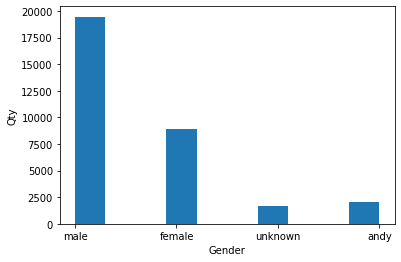

In [125]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(data_final['gender_final'])  # density=False would make counts
plt.ylabel('Qty')
plt.xlabel('Gender');

In [132]:
#table=data_final.value_counts(['YEAR', 'gender_final'])
table=data_final.value_counts(['YEAR', 'gender_final'])

In [133]:
table

YEAR  gender_final
2020  male            3911
2021  male            3421
2019  male            2633
2018  male            2118
2020  female          1834
                      ... 
1998  unknown            1
2000  unknown            1
2009  andy               1
1989  female             1
      andy               1
Length: 102, dtype: int64

In [134]:
#gender per year

per_year = pd.crosstab(data_final.YEAR, data_final.gender_final)
per_year

gender_final,andy,female,male,unknown
YEAR,,,,
1989,1,1,23,1
1991,0,2,23,2
1993,0,6,32,2
1995,0,1,18,2
1997,0,1,24,1
1998,1,24,24,1
2000,0,15,48,1
2001,0,18,35,6
2002,0,21,61,5


In [135]:
#reseteo el index para quedarme con la columna año
per_year= per_year.reset_index()
per_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   YEAR     28 non-null     int64
 1   andy     28 non-null     int64
 2   female   28 non-null     int64
 3   male     28 non-null     int64
 4   unknown  28 non-null     int64
dtypes: int64(5)
memory usage: 1.2 KB


In [136]:
#creamos el total por año
per_year['total'] = per_year['female'] + per_year['male'] + per_year['andy']+ per_year['unknown']


In [137]:
#creo % por genero por año
per_year['female_%'] = per_year['female'] / per_year['total'] * 100
per_year['male_%'] = per_year['male'] / per_year['total'] *100
per_year['andy_%'] = per_year['andy'] / per_year['total'] *100
per_year['unknown_%'] = per_year['unknown'] / per_year['total'] *100
per_year.head()

gender_final,YEAR,andy,female,male,unknown,total,female_%,male_%,andy_%,unknown_%
0,1989,1,1,23,1,26,3.846154,88.461538,3.846154,3.846154
1,1991,0,2,23,2,27,7.407407,85.185185,0.000000,7.407407
2,1993,0,6,32,2,40,15.000000,80.000000,0.000000,5.000000
3,1995,0,1,18,2,21,4.761905,85.714286,0.000000,9.523810
4,1997,0,1,24,1,26,3.846154,92.307692,0.000000,3.846154


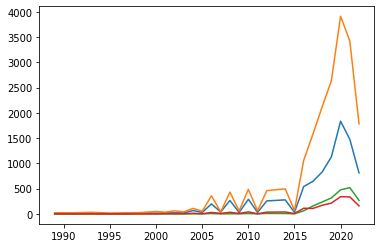

In [139]:
#gender per year

import numpy as np
import matplotlib.pyplot as plt

Y = per_year['female']
M = per_year['male']
Z= per_year['andy']
F= per_year['unknown']
X = per_year['YEAR']

fig, ax = plt.subplots()
ax.plot(X,Y,X,M,X,Z,X,F)
fig.show()

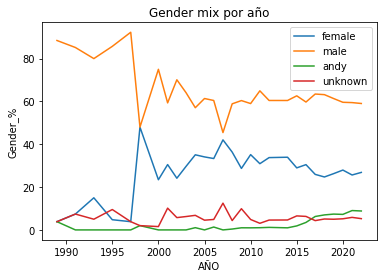

In [140]:
Y = per_year['female_%']
M = per_year['male_%']
Z= per_year['andy_%']
F= per_year['unknown_%']
X = per_year['YEAR']

fig, ax = plt.subplots()
ax.plot(X,Y, label='female')
ax.plot(X,M, label='male')
ax.plot(X,Z, label='andy')
ax.plot(X,F, label='unknown')
ax.set_title('Gender mix por año')
ax.set_xlabel('AÑO') 
ax.set_ylabel('Gender_%') 
ax.legend(loc='best')
fig.show()

In [141]:
per_year.reset_index()
per_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   YEAR       28 non-null     int64  
 1   andy       28 non-null     int64  
 2   female     28 non-null     int64  
 3   male       28 non-null     int64  
 4   unknown    28 non-null     int64  
 5   total      28 non-null     int64  
 6   female_%   28 non-null     float64
 7   male_%     28 non-null     float64
 8   andy_%     28 non-null     float64
 9   unknown_%  28 non-null     float64
dtypes: float64(4), int64(6)
memory usage: 2.3 KB


In [142]:
per_year.set_index('YEAR')
#per_year.head()

gender_final,andy,female,male,unknown,total,female_%,male_%,andy_%,unknown_%
YEAR,,,,,,,,,
1989,1,1,23,1,26,3.846154,88.461538,3.846154,3.846154
1991,0,2,23,2,27,7.407407,85.185185,0.000000,7.407407
1993,0,6,32,2,40,15.000000,80.000000,0.000000,5.000000
1995,0,1,18,2,21,4.761905,85.714286,0.000000,9.523810
1997,0,1,24,1,26,3.846154,92.307692,0.000000,3.846154
1998,1,24,24,1,50,48.000000,48.000000,2.000000,2.000000
2000,0,15,48,1,64,23.437500,75.000000,0.000000,1.562500
2001,0,18,35,6,59,30.508475,59.322034,0.000000,10.169492
2002,0,21,61,5,87,24.137931,70.114943,0.000000,5.747126


In [ ]:
per_year.head()

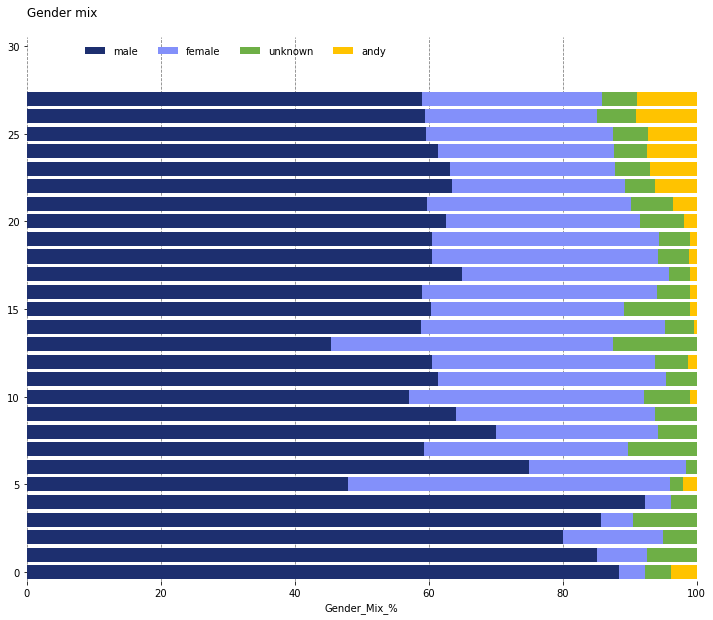

In [144]:


fields = ['male_%','female_%','unknown_%','andy_%']
colors = ['#1D2F6F', '#8390FA', '#6EAF46','#FFC300']
labels = ['male', 'female', 'unknown','andy']
# figure and axis
fig, ax = plt.subplots(1, figsize=(12, 10))
# plot bars
left = len(per_year) * [0]
for idx, name in enumerate(fields):
    plt.barh(per_year.index, per_year[name], left = left, color=colors[idx])
    left = left + per_year[name]
# title, legend, labels
plt.title('Gender mix\n', loc='left')
plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Gender_Mix_%')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

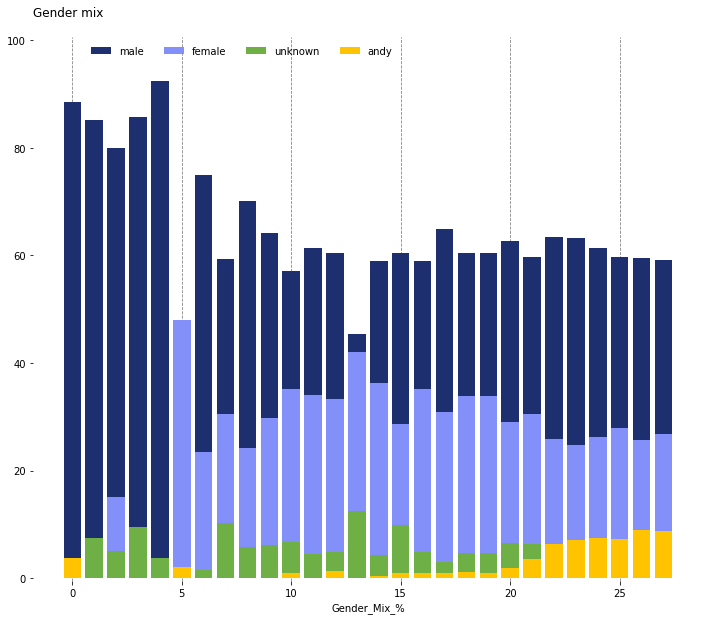

In [145]:


fields = ['male_%','female_%','unknown_%','andy_%']
colors = ['#1D2F6F', '#8390FA', '#6EAF46','#FFC300']
labels = ['male', 'female', 'unknown','andy']
# figure and axis
fig, ax = plt.subplots(1, figsize=(12, 10))
# plot bars
left = len(per_year) * [0]
for idx, name in enumerate(fields):
    plt.bar(per_year.index, per_year[name], color=colors[idx])
    
# title, legend, labels
plt.title('Gender mix\n', loc='left')
plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Gender_Mix_%')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

IndexError: ignored

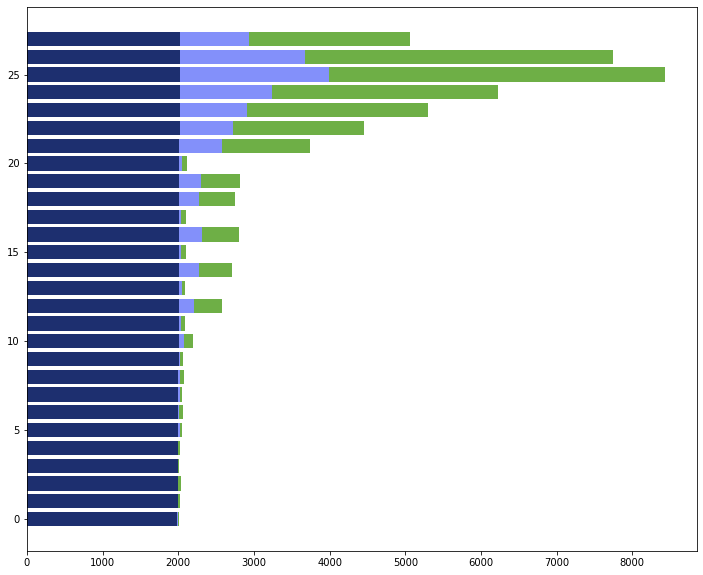

In [ ]:
# variables
fields = ['male_%','female_%','unknown_%']
colors = ['#1D2F6F', '#8390FA', '#6EAF46']

title = 'Video Game Sales By Platform and Region\n'
subtitle = 'Proportion of Games Sold by Region'
def plot_stackedbar_p(per_year, labels, colors, title, subtitle):
    fields = per_year.columns.tolist()
    
    # figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 10))
# plot bars
    left = len(per_year) * [0]
    for idx, name in enumerate(fields):
        plt.barh(per_year.index, per_year[name], left = left, color=colors[idx])
        left = left + per_year[name]
# title and subtitle
    plt.title(title, loc='left')
    plt.text(0, ax.get_yticks()[-1] + 0.75, subtitle)
# legend
    plt.legend(labels, bbox_to_anchor=([0.58, 1, 0, 0]), ncol=4, frameon=False)
# remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
# format x ticks
    xticks = np.arange(0,1.1,0.1)
    xlabels = ['{}%'.format(i) for i in np.arange(0,101,10)]
    plt.xticks(xticks, xlabels)
# adjust limits and draw grid lines
    plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
    ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()
    
plot_stackedbar_p(per_year, labels, colors, title, subtitle)

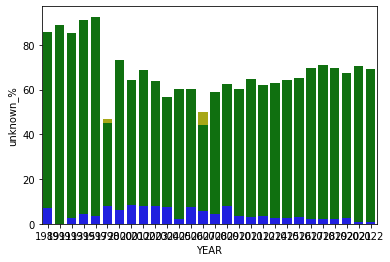

In [ ]:
import seaborn as sns

bar_plot1 = sns.barplot(x='YEAR', y='female_%', data=per_year, label="female_%", color="y")
bar_plot2 = sns.barplot(x='YEAR', y='male_%', data=per_year, label="male_%", color="g")
bar_plot3 = sns.barplot(x='YEAR', y='unknown_%', data=per_year, label="unknown_%", color="b")

plt.show()

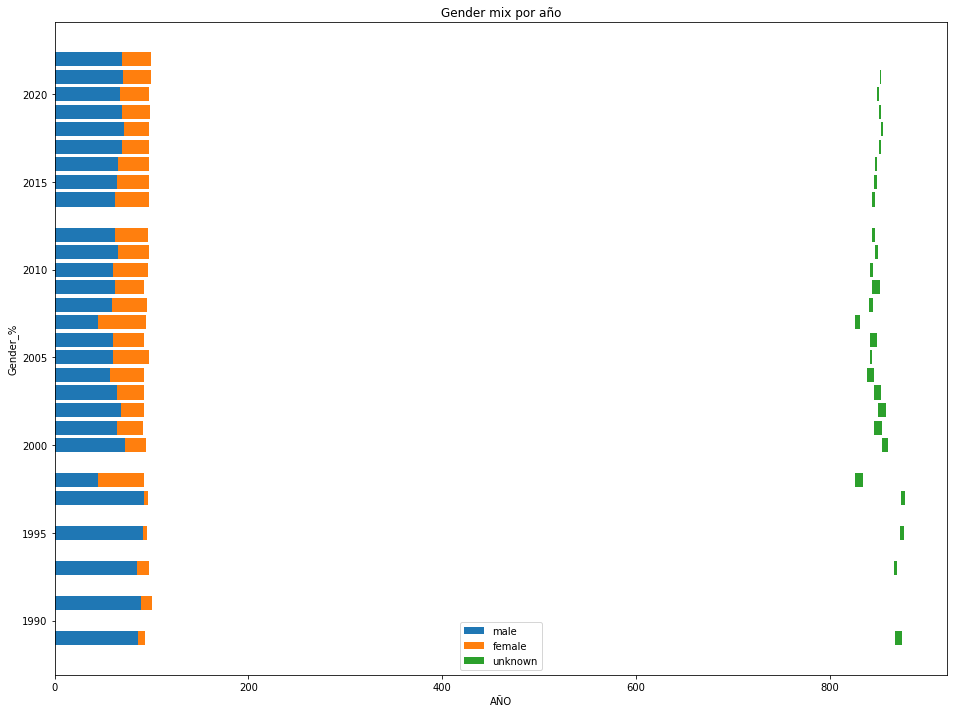

In [ ]:
# Define Data

año = per_year['YEAR']
female = per_year['female_%']
male = per_year['male_%']
unknown = per_year['unknown_%']
a = female + male

# Define height of stacked chart


h = 1

# Plot stacked bar chart



# Display
fig, ax = plt.subplots(1, figsize=(16, 12))
ax.barh(año, male, label = 'male')
ax.barh(año, female, left=male, label = 'female')
ax.barh(año, unknown, left=sum(female,male), label = 'unknown')


ax.set_title('Gender mix por año')
ax.set_xlabel('AÑO') 
ax.set_ylabel('Gender_%') 
ax.legend(loc='best')



plt.show()